In [1]:
import numpy as np
import os
from ipywidgets import IntProgress
from scipy.signal import convolve
import matplotlib.pyplot as plt
from tensorflow import keras
from utility_functions import relu,relu_prime,sigmoid,averager,extract_averager_value
import sys

%matplotlib inline

# Multiclass Classifier

Now we generalize very quickly to colored and multi-class images. We also allow for multiple convolution filters. Concretely we allow $M$ to run over the channels of the images (if this were a layer on top of another convolutional layer the channels would be the output of independent filters from the previous layer). This layer is embeded in zero padded bigger array as before.

**Forward Pass**

$$
\tilde l^0_{i+K//2,j+K//2,M}=l^0_{ij;M}
$$

The convolutional filters produces layer


$$
l^1_{ij Z}=f^1(\sum \tilde l^0_{i+\alpha,j+\beta;M} W^1_{\alpha\beta M Z})
$$

where as before we take the activation function to be Relu. 

Layer 2 is a dense layer that we wrap in a softmax

$$
l^2_\alpha = f^2( l^1_{ijZ} W^2_{ijZ\alpha})\\
= \frac{exp(l^1_{ijZ} W^2_{ijZ\alpha})}{\sum_\beta exp(l^1_{ijZ} W^2_{ijZ\beta})}
$$

**Loss Function**

The loss function is

$$
L =  - l^1_{ijZ} W^2_{ijZy} + \log( \sum_\alpha exp(l^1_{ijZ} W^2_{ijZ\alpha}))
$$


**Back Propagation**

The back propagation is obtained by derivatives of the loss function wrt to the weights

$$
\frac{\partial L}{\partial l^1_{ijZ}}=-W^2_{ijZy}+\sum W^2_{ijZ\alpha} l^2_\alpha
$$

$$
\frac{\partial L}{\partial W^2_{ijZ\beta}}=-l^1_{ijZ} \delta_{y \beta}+ l^1_{ijZ} l^2_\beta
$$


$$
\frac{\partial L}{\partial W^1_{\alpha \beta M Z}} = \sum_{ij} \frac{\partial L}{\partial l^1_{ijZ}} (f^1)' \tilde l^0_{i+\alpha,j+\beta;M}
$$


In [2]:
def batch_generator(X,y,batch_size,total_count):
    idx=np.arange(0,len(y))
    for i in range(total_count):
        idx_batch=np.random.choice(idx,batch_size)
        yield X[idx_batch],y[idx_batch]

In [3]:
def forward_pass_batch(W1,W2,X_batch,y_batch):
    batch_size=len(y_batch)
    idx_batch_size=range(batch_size)
    l0=X_batch

    for n in range(batch_size):
        for j in range(num_filters):
            l0_conv[n,:,:,j]=convolve(l0[n],W1[::-1,::-1,::-1,j],'same')[:,:,num_channels//2]    
    l1=relu(l0_conv)

    l1_dot_W2=l1.reshape(batch_size,-1).dot(W2)

    p_un=np.exp(l1_dot_W2)
    p_sum=p_un.sum(1)
    l2=p_un/p_un.sum(1)[:,None]
    loss=-l1_dot_W2[idx_batch_size,y_batch]+np.log(p_sum)
    accuracy=l2.argmax(1)==y_batch

    return loss.mean(),accuracy.mean()


## Fashion MNIST

In [4]:
DATASET='FASHION_MNIST'

if DATASET=='CIFAR10':
    print('Using CIFAR10')
    (X_train_full, y_train_full), (X_test, y_test)  = keras.datasets.cifar10.load_data()
if DATASET=='CIFAR100':
    print('Using CIFAR100')
    (X_train_full, y_train_full), (X_test, y_test)  = keras.datasets.cifar100.load_data()
else:
    print('Using Fashion_MNIST')
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

if len(X_train_full.shape)==3:
    X_train = X_train[..., np.newaxis]
    X_valid = X_valid[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

y_train=y_train.flatten()
y_valid=y_valid.flatten()
y_test=y_test.flatten()

Using Fashion_MNIST


In [5]:
K=3
num_channels=X_train.shape[3]
image_size=X_train.shape[1]
image_size_embedding_size=image_size+K-1

eta=.001
batch_size=32
idx_batch_size=list(range(batch_size))
num_steps=len(y_train)//batch_size

lt0=np.zeros((batch_size,image_size_embedding_size,image_size_embedding_size,num_channels))
num_categories=len(set(list(y_train)))

In [7]:
for num_filters in (1, 10, 20):

    np.random.seed(42)
    W1 = np.random.normal(0, 1 / np.sqrt(K * K * num_channels),
                          size=(K, K, num_channels, num_filters))
    W2 = np.random.normal(0, 1 / np.sqrt(num_filters * image_size * image_size),
                          size=(num_filters * image_size * image_size, num_categories))

    l0_conv = np.zeros((batch_size, image_size, image_size, num_filters))
    l1 = np.zeros_like(l0_conv)
    f1p = np.zeros_like(l0_conv)

    print('Training with num filters {}'.format(num_filters))

    for epoch in range(1):
        train_loss = averager()
        train_accuracy = averager()

        for i, (X_batch, y_batch) in enumerate(
                batch_generator(X_train, y_train, batch_size, num_steps)):
            if (i + 1) % 10 == 0:
                sys.stdout.write('Epoch: {} Step {}/{}\r'.format(epoch+1,i+1,num_steps))

            l0 = X_batch
            # lt0=np.zeros((l0.shape[0],l0.shape[1]+K-1,l0.shape[2]+K-1,l0.shape[3]))
            lt0[:] = 0
            lt0[:, K // 2:-K // 2 + 1, K // 2:-K // 2 + 1] = l0

            for n in range(batch_size):
                for j in range(num_filters):
                    l0_conv[n, :, :, j] = convolve(l0[n], W1[::-1, ::-1, ::-1, j], 'same')[:, :,
                                          num_channels // 2]
            l1[:] = 0
            f1p[:] = 0
            l1[:] = relu(l0_conv)
            f1p[:] = relu_prime(l0_conv)

            l1_dot_W2 = l1.reshape(batch_size, -1).dot(W2)

            p_un = np.exp(l1_dot_W2)
            p_sum = p_un.sum(1)
            l2 = p_un / p_un.sum(1)[:, None]
            loss = -l1_dot_W2[idx_batch_size, y_batch] + np.log(p_sum)
            accuracy = l2.argmax(1) == y_batch
            train_loss.send(loss.mean())
            train_accuracy.send(accuracy.mean())

            d = np.zeros(shape=(batch_size, num_categories))
            d[idx_batch_size, y_batch] = 1

            dW2 = (l1.reshape(batch_size, -1)[:, :, None] * (l2 - d)[:, None, :])

            dl1 = (l2.dot(W2.T) - W2[:, y_batch].T).reshape(batch_size, image_size, image_size,
                                                            num_filters)

            dl1_f1p = (dl1 * f1p)

            dW1 = np.array([[(lt0[:, alpha:image_size_embedding_size + alpha - (K - 1),
                              beta:image_size_embedding_size + beta - (K - 1)][:, :, :, :, None] \
                              * dl1_f1p[:, :, :, None, :]).sum((1, 2)) \
                             for beta in range(K)] for alpha in range(K)]).transpose(2, 0, 1, 3, 4)

            W2 += -eta * dW2.sum(0)
            W1 += -eta * dW1.sum(0)

        loss_averager_valid = averager()
        accuracy_averager_valid = averager()

        for X_valid_batch, y_valid_batch in batch_generator(X_valid, y_valid, batch_size,
                                                            len(y_valid) // batch_size):
            loss, accuracy = forward_pass_batch(W1, W2, X_valid_batch, y_valid_batch)
            loss_averager_valid.send(loss)
            accuracy_averager_valid.send(accuracy)

        train_loss, train_accuracy, valid_loss, valid_accuracy = map(extract_averager_value, [
            train_loss,
            train_accuracy,
            loss_averager_valid,
            accuracy_averager_valid]
                                                                     )
        msg = 'Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(
            epoch + 1,
            train_loss,
            train_accuracy,
            valid_loss,
            valid_accuracy
            )
        print(msg)
    print()


Training with num filters 1
Epoch 1: train loss 0.60, train acc 0.80, valid loss 0.49, valid acc 0.83

Training with num filters 10
Epoch 1: train loss 0.42, train acc 0.85, valid loss 0.36, valid acc 0.88

Training with num filters 20


KeyboardInterrupt: 

## CIFAR - 10

In [10]:
DATASET='CIFAR10'

if DATASET=='CIFAR10':
    print('Using CIFAR10')
    (X_train_full, y_train_full), (X_test, y_test)  = keras.datasets.cifar10.load_data()
elif DATASET=='CIFAR100':
    print('Using CIFAR100')
    (X_train_full, y_train_full), (X_test, y_test)  = keras.datasets.cifar100.load_data()
else:
    print('Using Fashion_MNIST')
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

if len(X_train_full.shape)==3:
    X_train = X_train[..., np.newaxis]
    X_valid = X_valid[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

y_train=y_train.flatten()
y_valid=y_valid.flatten()
y_test=y_test.flatten()

Using CIFAR10


In [11]:
K=3
num_channels=X_train.shape[3]
image_size=X_train.shape[1]
image_size_embedding_size=image_size+K-1

eta=.001
batch_size=32
idx_batch_size=list(range(batch_size))
num_steps=len(y_train)//batch_size

lt0=np.zeros((batch_size,image_size_embedding_size,image_size_embedding_size,num_channels))
num_categories=len(set(list(y_train)))

In [ ]:
for num_filters in (1, 10, 20):

    np.random.seed(42)
    W1 = np.random.normal(0, 1 / np.sqrt(K * K * num_channels),
                          size=(K, K, num_channels, num_filters))
    W2 = np.random.normal(0, 1 / np.sqrt(num_filters * image_size * image_size),
                          size=(num_filters * image_size * image_size, num_categories))

    l0_conv = np.zeros((batch_size, image_size, image_size, num_filters))
    l1 = np.zeros_like(l0_conv)
    f1p = np.zeros_like(l0_conv)

    print('Training with num filters {}'.format(num_filters))

    for epoch in range(1):
        train_loss = averager()
        train_accuracy = averager()

        for i, (X_batch, y_batch) in enumerate(
                batch_generator(X_train, y_train, batch_size, num_steps)):
            if (i + 1) % 10 == 0:
                sys.stdout.write('Epoch: {} Step {}/{}\r'.format(epoch+1,i+1,num_steps))

            l0 = X_batch
            # lt0=np.zeros((l0.shape[0],l0.shape[1]+K-1,l0.shape[2]+K-1,l0.shape[3]))
            lt0[:] = 0
            lt0[:, K // 2:-K // 2 + 1, K // 2:-K // 2 + 1] = l0

            for n in range(batch_size):
                for j in range(num_filters):
                    l0_conv[n, :, :, j] = convolve(l0[n], W1[::-1, ::-1, ::-1, j], 'same')[:, :,
                                          num_channels // 2]
            l1[:] = 0
            f1p[:] = 0
            l1[:] = relu(l0_conv)
            f1p[:] = relu_prime(l0_conv)

            l1_dot_W2 = l1.reshape(batch_size, -1).dot(W2)

            p_un = np.exp(l1_dot_W2)
            p_sum = p_un.sum(1)
            l2 = p_un / p_un.sum(1)[:, None]
            loss = -l1_dot_W2[idx_batch_size, y_batch] + np.log(p_sum)
            accuracy = l2.argmax(1) == y_batch
            train_loss.send(loss.mean())
            train_accuracy.send(accuracy.mean())

            d = np.zeros(shape=(batch_size, num_categories))
            d[idx_batch_size, y_batch] = 1

            dW2 = (l1.reshape(batch_size, -1)[:, :, None] * (l2 - d)[:, None, :])

            dl1 = (l2.dot(W2.T) - W2[:, y_batch].T).reshape(batch_size, image_size, image_size,
                                                            num_filters)

            dl1_f1p = (dl1 * f1p)

            dW1 = np.array([[(lt0[:, alpha:image_size_embedding_size + alpha - (K - 1),
                              beta:image_size_embedding_size + beta - (K - 1)][:, :, :, :, None] \
                              * dl1_f1p[:, :, :, None, :]).sum((1, 2)) \
                             for beta in range(K)] for alpha in range(K)]).transpose(2, 0, 1, 3, 4)

            W2 += -eta * dW2.sum(0)
            W1 += -eta * dW1.sum(0)

        loss_averager_valid = averager()
        accuracy_averager_valid = averager()

        for X_valid_batch, y_valid_batch in batch_generator(X_valid, y_valid, batch_size,
                                                            len(y_valid) // batch_size):
            loss, accuracy = forward_pass_batch(W1, W2, X_valid_batch, y_valid_batch)
            loss_averager_valid.send(loss)
            accuracy_averager_valid.send(accuracy)

        train_loss, train_accuracy, valid_loss, valid_accuracy = map(extract_averager_value, [
            train_loss,
            train_accuracy,
            loss_averager_valid,
            accuracy_averager_valid]
                                                                     )
        msg = 'Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(
            epoch + 1,
            train_loss,
            train_accuracy,
            valid_loss,
            valid_accuracy
            )
        print(msg)
    print()


Training with num filters 1


In [90]:
W1.shape

((3, 3, 3, 30), 32)

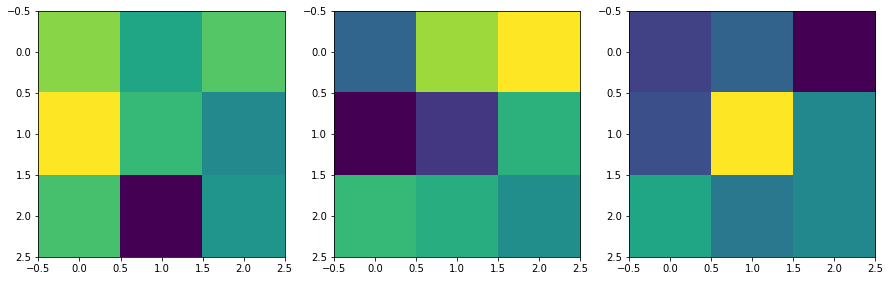

In [50]:
_,axs=plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    axs[i].imshow(W1[:,:,i,0])

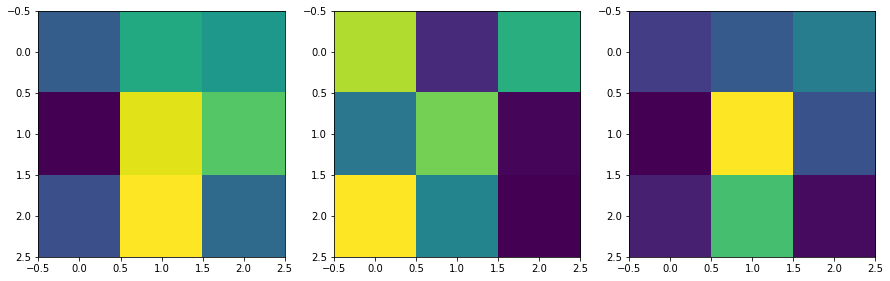

In [52]:
_,axs=plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    axs[i].imshow(W1[:,:,i,1])

In [73]:
W1.shape

(3, 3, 3, 30)

W1108 07:56:34.743472 4633597376 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


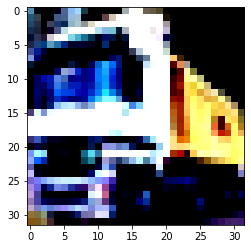

In [86]:
plt.imshow(X_train[1])

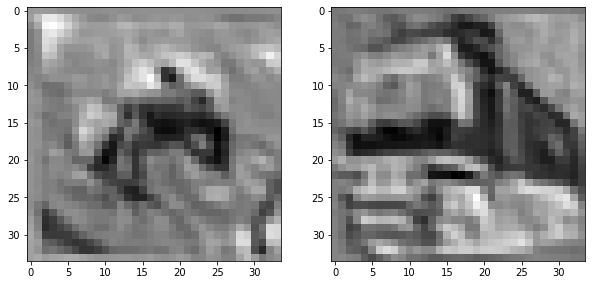

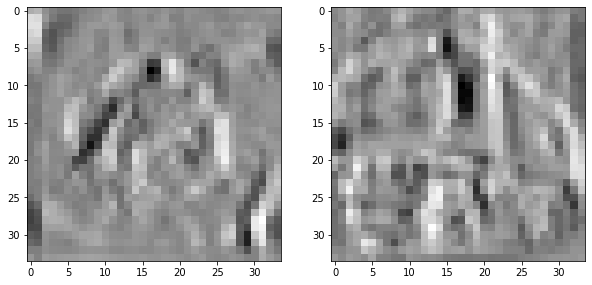

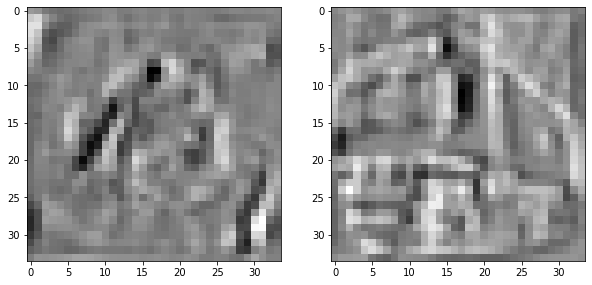

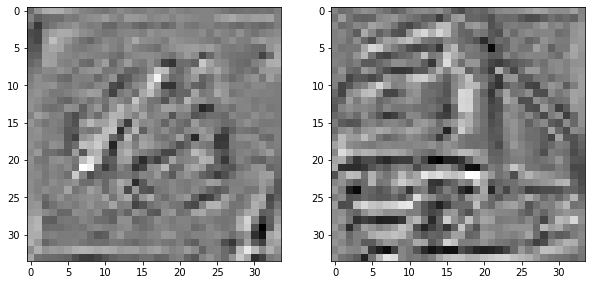

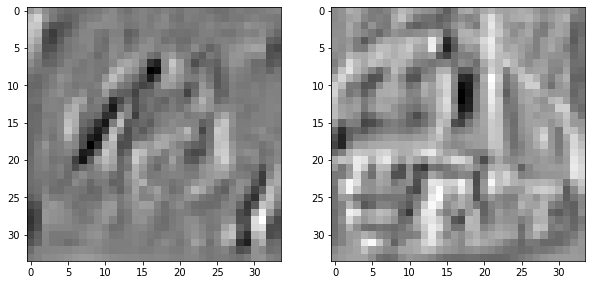

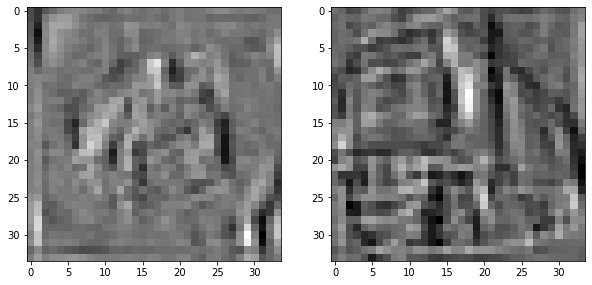

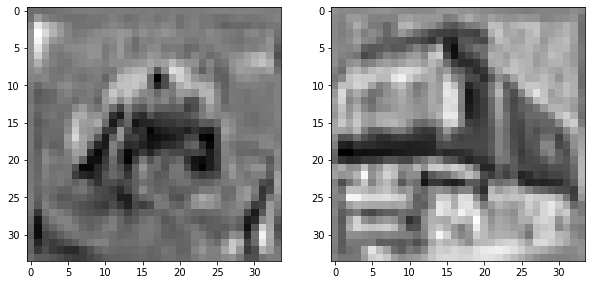

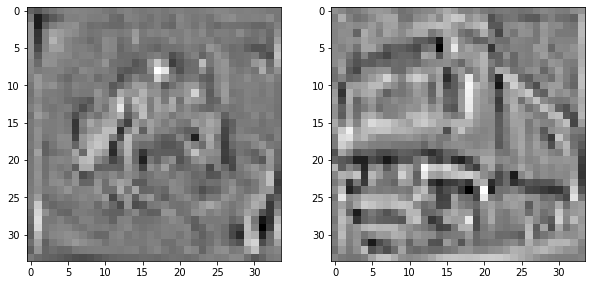

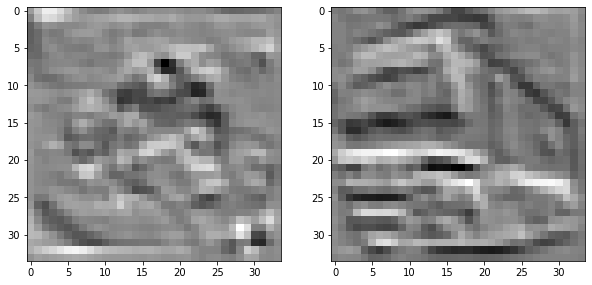

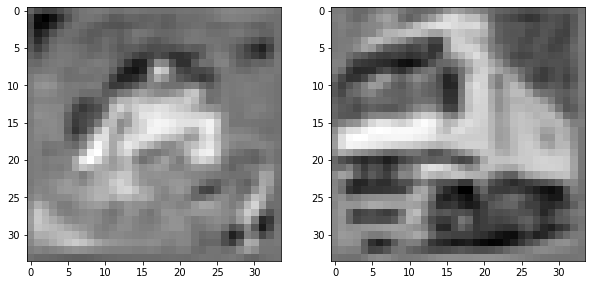

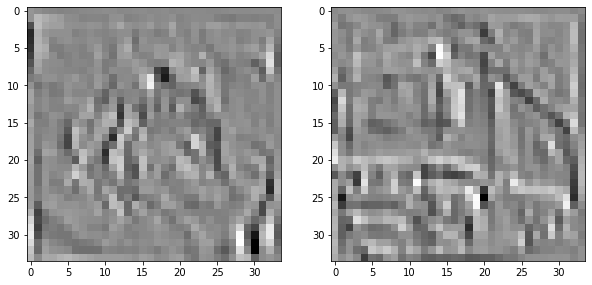

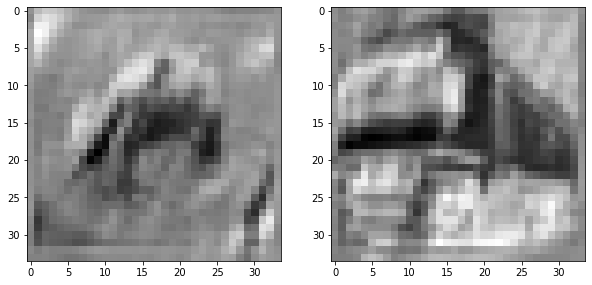

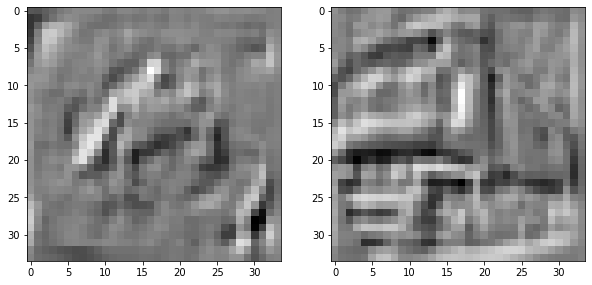

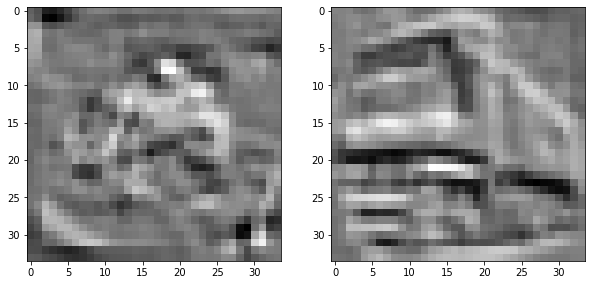

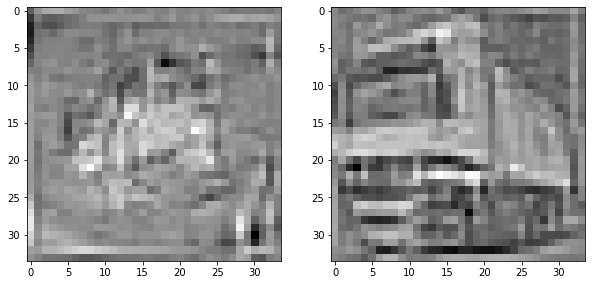

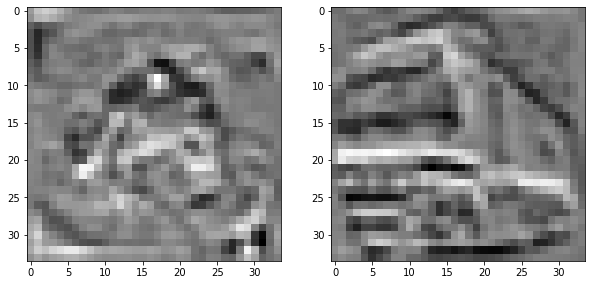

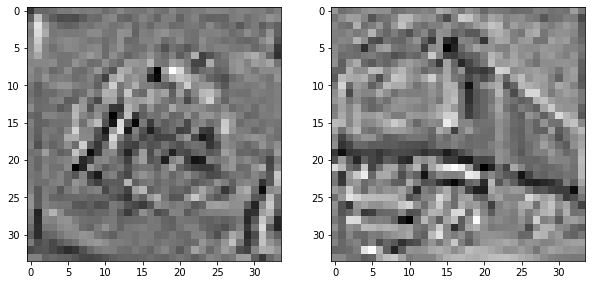

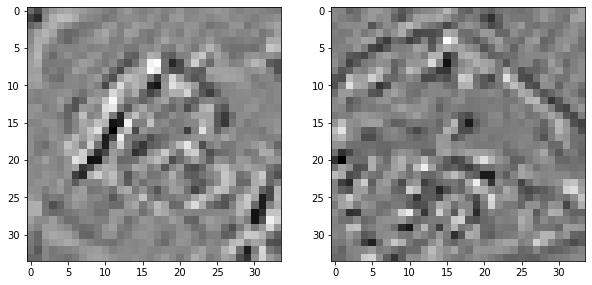

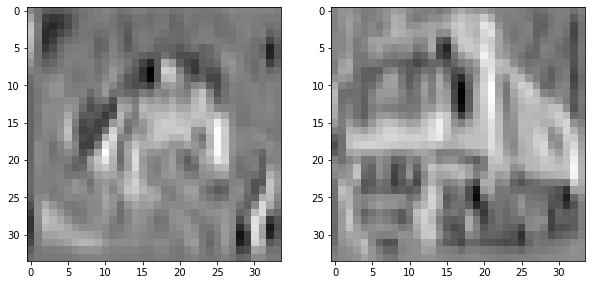

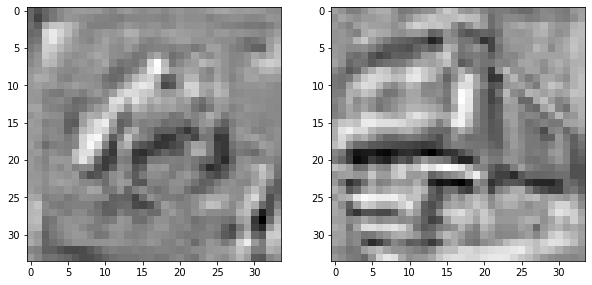

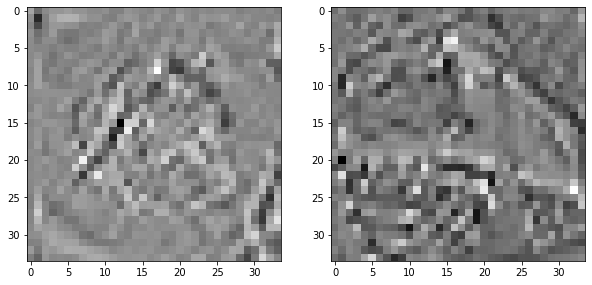

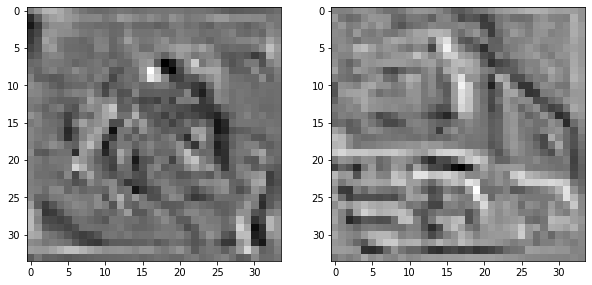

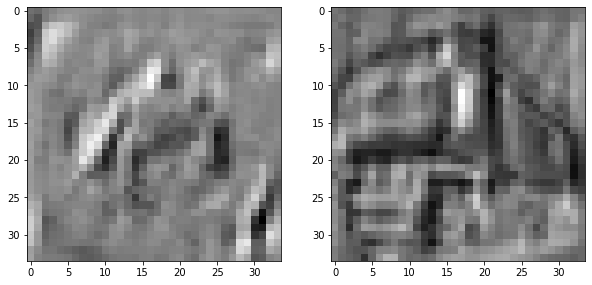

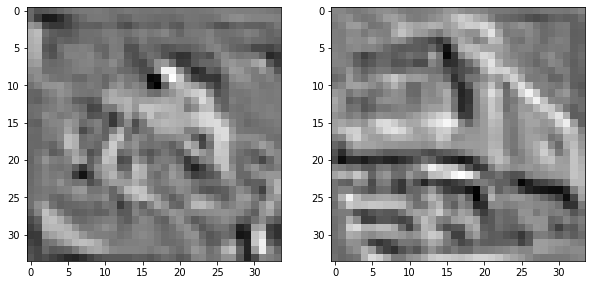

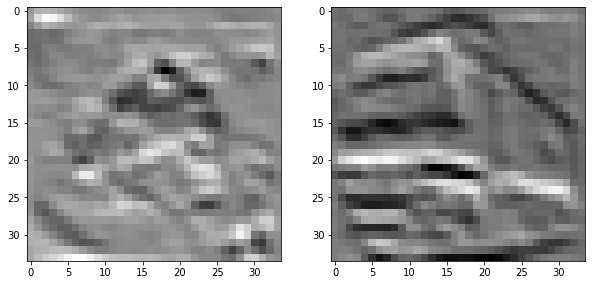

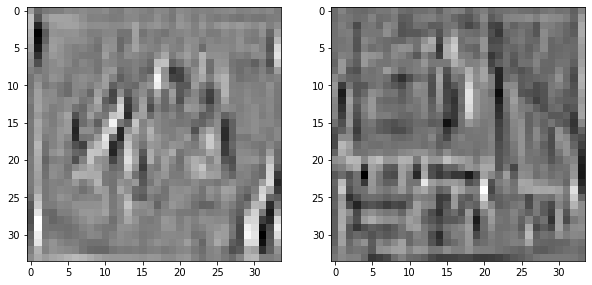

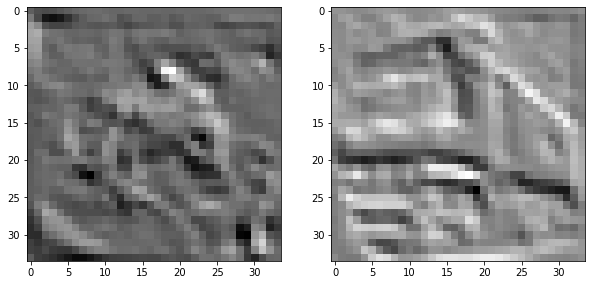

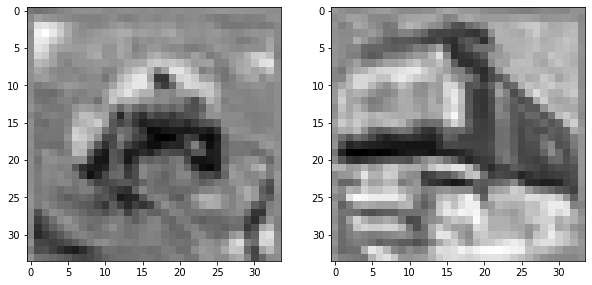

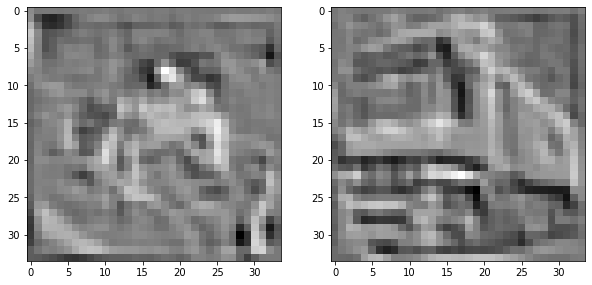

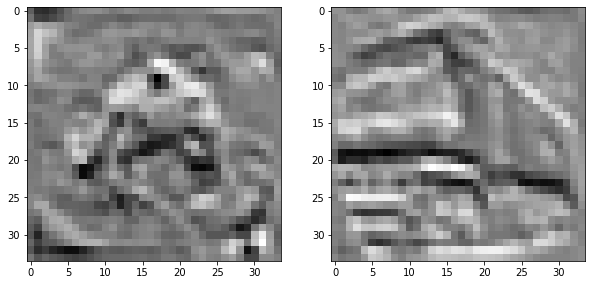

In [87]:
for i in range(30):
    _,axs=plt.subplots(1,2,figsize=(15,5))
    axs[0].imshow(convolve(X_train[0][:,:,0],W1[::-1,::-1,1,i]),cmap='gray')
    axs[1].imshow(convolve(X_train[1][:,:,0],W1[::-1,::-1,1,i]),cmap='gray')
    plt.show()

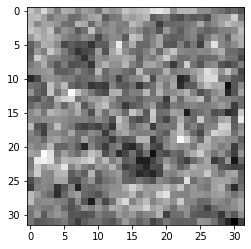

In [98]:
plt.imshow(W2.reshape(32,32,30,10)[:,:,0,0],cmap='gray')

In [28]:
K=3
np.random.seed(42)
num_filters=15
num_channels=3
image_size=X_train.shape[1]
image_size_embedding_size=image_size+K-1

W1=np.random.normal(0,1/np.sqrt(K*K*num_channels),size=(K,K,num_channels,num_filters))
W2=np.random.normal(0,1/np.sqrt(num_filters*image_size*image_size),size=(num_filters*image_size*image_size,10))

W1_original=W1.copy()
W2_original=W2.copy()

In [29]:
eta=.001
batch_size=32
idx_batch_size=list(range(batch_size))
num_steps=len(y_train)//batch_size

In [30]:
lt0=np.zeros((batch_size,image_size_embedding_size,image_size_embedding_size,num_channels))
l0_conv=np.zeros((batch_size,image_size,image_size,num_filters))
l1=np.zeros_like(l0_conv)
f1p=np.zeros_like(l0_conv)

In [31]:
train_loss=averager()
train_accuracy=averager()

loss_averager_valid=averager()
accuracy_averager_valid=averager()
    
for X_valid_batch,y_valid_batch in batch_generator(X_valid,y_valid,batch_size,len(y_valid)//batch_size):
    loss,accuracy=forward_pass_batch(W1_original,W2_original,X_valid_batch,y_valid_batch)
    loss_averager_valid.send(loss)
    accuracy_averager_valid.send(accuracy)
    
for X_valid_batch,y_valid_batch in batch_generator(X_train,y_train,batch_size,len(y_valid)//batch_size):
    loss,accuracy=forward_pass_batch(W1_original,W2_original,X_valid_batch,y_valid_batch)
    train_loss.send(loss)
    train_accuracy.send(accuracy)
    
    
train_loss,train_accuracy,valid_loss,valid_accuracy=map(extract_averager_value,[
                                                        train_loss,
                                                        train_accuracy,
                                                        loss_averager_valid,
                                                        accuracy_averager_valid]
                                                       )

msg='Before Training: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(
                                                                                                  train_loss,
                                                                                                  train_accuracy,
                                                                                                  valid_loss,
                                                                                                  valid_accuracy
                                                                                                 )
print(msg)


Before Training: train loss 2.43, train acc 0.10, valid loss 2.42, valid acc 0.10


In [32]:
np.random.seed(42)

w=IntProgress(max=num_steps)
display(w)
for epoch in range(5):
    train_loss=averager()
    train_accuracy=averager()
    
    w.value=0
    for i,(X_batch,y_batch) in enumerate(batch_generator(X_train,y_train,batch_size,num_steps)):
        if (i+1) % 10 ==0:
            w.value=i+1
            
        l0=X_batch
        #lt0=np.zeros((l0.shape[0],l0.shape[1]+K-1,l0.shape[2]+K-1,l0.shape[3]))
        lt0[:]=0
        lt0[:,K//2:-K//2+1,K//2:-K//2+1]=l0

        for n in range(batch_size):
            for j in range(num_filters):
                l0_conv[n,:,:,j]=convolve(l0[n],W1[::-1,::-1,::-1,j],'same')[:,:,num_channels//2]
        l1[:]=0
        f1p[:]=0
        l1[:]=relu(l0_conv)
        f1p[:]=relu_prime(l0_conv)

        l1_dot_W2=l1.reshape(batch_size,-1).dot(W2)

        p_un=np.exp(l1_dot_W2)
        p_sum=p_un.sum(1)
        l2=p_un/p_un.sum(1)[:,None]
        loss=-l1_dot_W2[idx_batch_size,y_batch]+np.log(p_sum)
        accuracy=l2.argmax(1)==y_batch
        train_loss.send(loss.mean())
        train_accuracy.send(accuracy.mean())

        d=np.zeros(shape=(batch_size,10))
        d[idx_batch_size,y_batch]=1

        dW2=(l1.reshape(batch_size,-1)[:,:,None]*(l2-d)[:,None,:])

        dl1=(l2.dot(W2.T)-W2[:,y_batch].T).reshape(batch_size,image_size,image_size,num_filters)

        dl1_f1p=(dl1*f1p)

        dW1=np.array([[(lt0[:,alpha:image_size_embedding_size+alpha-(K-1),beta:image_size_embedding_size+beta-(K-1)][:,:,:,:,None]\
                        *dl1_f1p[:,:,:,None,:]).sum((1,2)) \
                       for beta in range(K)] for alpha in range(K)]).transpose(2,0,1,3,4)
        
        W2+=-eta*dW2.sum(0)
        W1+=-eta*dW1.sum(0)
        
    
        
    
    
    
    loss_averager_valid=averager()
    accuracy_averager_valid=averager()
    
    for X_valid_batch,y_valid_batch in batch_generator(X_valid,y_valid,batch_size,len(y_valid)//batch_size):
        loss,accuracy=forward_pass_batch(W1,W2,X_valid_batch,y_valid_batch)
        loss_averager_valid.send(loss)
        accuracy_averager_valid.send(accuracy)
    
    train_loss,train_accuracy,valid_loss,valid_accuracy=map(extract_averager_value,[
                                                            train_loss,
                                                            train_accuracy,
                                                            loss_averager_valid,
                                                            accuracy_averager_valid]
                                                           )
    msg='Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(epoch+1,
                                                                                                      train_loss,
                                                                                                      train_accuracy,
                                                                                                      valid_loss,
                                                                                                      valid_accuracy
                                                                                                     )
    print(msg)

    
    
    

IntProgress(value=0, max=1406)

Epoch 1: train loss 1.59, train acc 0.46, valid loss 1.58, valid acc 0.46


KeyboardInterrupt: 

# Using tensorflow and Keras

In [164]:
import tensorflow as tf
from tensorflow import keras

In [185]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, 
                        activation='relu',
                        padding="SAME",
                        use_bias=False
                       )


In [186]:
model = keras.models.Sequential([
    DefaultConv2D(filters=5, input_shape=[32, 32, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10, 
                       use_bias=False,
                       activation='softmax'),
])

In [187]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 5)         135       
_________________________________________________________________
flatten_11 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                51200     
Total params: 51,335
Trainable params: 51,335
Non-trainable params: 0
_________________________________________________________________


In [189]:
%%time
model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd', metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=[X_valid, y_valid])


Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 16s 355us/sample - loss: 1.7213 - accuracy: 0.3928 - val_loss: 1.6436 - val_accuracy: 0.4136
Epoch 2/5
45000/45000 [==============================] - 15s 337us/sample - loss: 1.5512 - accuracy: 0.4567 - val_loss: 1.6951 - val_accuracy: 0.4020
Epoch 3/5
45000/45000 [==============================] - 21s 460us/sample - loss: 1.4923 - accuracy: 0.4765 - val_loss: 1.5396 - val_accuracy: 0.4626
Epoch 4/5
45000/45000 [==============================] - 14s 319us/sample - loss: 1.4414 - accuracy: 0.4966 - val_loss: 1.6285 - val_accuracy: 0.4448
Epoch 5/5
45000/45000 [==============================] - 15s 340us/sample - loss: 1.3897 - accuracy: 0.5153 - val_loss: 1.6575 - val_accuracy: 0.4250
CPU times: user 2min 20s, sys: 42.2 s, total: 3min 2s
Wall time: 1min 23s


In [170]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, 
                        activation='relu',
                        padding="SAME",
                       )


In [171]:
model = keras.models.Sequential([
    DefaultConv2D(filters=5, input_shape=[32, 32, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10, 
                       activation='softmax'),
])

In [172]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 5)         140       
_________________________________________________________________
flatten_5 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                51210     
Total params: 51,350
Trainable params: 51,350
Non-trainable params: 0
_________________________________________________________________


In [173]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=[X_valid, y_valid])


Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 20s 445us/sample - loss: 1.6110 - accuracy: 0.4362 - val_loss: 1.4335 - val_accuracy: 0.4966
Epoch 2/5
45000/45000 [==============================] - 21s 460us/sample - loss: 1.3592 - accuracy: 0.5276 - val_loss: 1.3860 - val_accuracy: 0.5184
Epoch 3/5
45000/45000 [==============================] - 20s 435us/sample - loss: 1.2806 - accuracy: 0.5587 - val_loss: 1.3853 - val_accuracy: 0.5172
Epoch 4/5
45000/45000 [==============================] - 18s 392us/sample - loss: 1.2244 - accuracy: 0.5801 - val_loss: 1.4058 - val_accuracy: 0.5230
Epoch 5/5
45000/45000 [==============================] - 18s 396us/sample - loss: 1.1834 - accuracy: 0.5952 - val_loss: 1.3834 - val_accuracy: 0.5284


In [182]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=[32, 32, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [183]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 256)       

In [184]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=[X_valid, y_valid])


Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 516s 11ms/sample - loss: 1.7558 - accuracy: 0.3552 - val_loss: 1.7101 - val_accuracy: 0.4514
Epoch 2/5
45000/45000 [==============================] - 1334s 30ms/sample - loss: 1.3051 - accuracy: 0.5588 - val_loss: 1.1096 - val_accuracy: 0.6136
Epoch 3/5
45000/45000 [==============================] - 1142s 25ms/sample - loss: 1.2107 - accuracy: 0.6068 - val_loss: 1.3408 - val_accuracy: 0.6078
Epoch 4/5
45000/45000 [==============================] - 10551s 234ms/sample - loss: 1.2654 - accuracy: 0.6007 - val_loss: 1.2701 - val_accuracy: 0.6458
Epoch 5/5
45000/45000 [==============================] - 2524s 56ms/sample - loss: 1.3464 - accuracy: 0.5730 - val_loss: 1.1557 - val_accuracy: 0.6216
